In [1]:
import torch
from hydra import initialize, compose
from omegaconf import DictConfig

from kitten.common.rng import global_seed
from kitten.experience.collector import GymCollector
from kitten.experience.util import build_transition_from_list
from kitten.experience import Transitions, AuxiliaryMemoryData
from kitten.rl.common import td_lambda, generate_minibatches

import numpy as np

from matplotlib import pyplot as plt

from cats.agent.policy import ExplorationPolicy
from cats.agent.minigrid.value import MinigridValue
from cats.agent.experiment import ExperimentBase, build_env

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def visualise(ax,
              env,
              batch: Transitions | list[np.ndarray],
              density: bool = True,
):
    obs, _ = env.reset()

    draw_map = np.zeros(obs.shape)
    white = np.ones(obs.shape)
    red = np.zeros(obs.shape)
    red[:, :, 0] = 1
    green = np.zeros(obs.shape)
    green[:, :, 1] = 1
    blue = np.zeros(obs.shape)
    blue[:, :, 2] = 1

    # Draw walls
    has_wall = np.expand_dims((obs[:, :, 0] == 2), axis=-1)
    draw_map += white * has_wall * 0.8
    # Draw goal
    has_wall = np.expand_dims((obs[:, :, 0] == 8), axis=-1)
    draw_map += green * has_wall * 1

    # Draw agent exploration
    if isinstance(batch, Transitions):
        states = batch.s_0.detach().cpu().numpy()  # [batch, a, b, c]
    else:
        states = np.array(batch)
    has_agent = states[:, :, :, 0] == 10
    has_agent = np.sum(has_agent, axis=0)
    #has_agent = np.maximum(0, np.log(has_agent))
    has_agent = np.expand_dims(has_agent / has_agent.max(), axis=-1)
    if not density:
        has_agent = (has_agent>0)
    draw_map += red * has_agent

    ax.imshow(draw_map)

def grid(env, dir: int =0):
    obs, _ = env.reset()
    has_agent = obs[:, :, 0] == 10
    obs[:, :, 0] -= (has_agent * 9).astype(np.uint8)
    obs[:, :, 2] = 0
    grid = np.reshape(obs, (1,1, *obs.shape))
    grid = np.repeat(grid, len(obs), 0)
    grid = np.repeat(grid, len(obs), 1)
    for x in range(len(obs)):
        for y in range(len(obs)):
            grid[x,y,x,y,0] = 10
            grid[x,y,x,y,2] = dir
    return grid

pygame 2.5.2 (SDL 2.28.2, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
n_update_epochs = 4
minibatch_size = 32

class TeleportStrategyExperiment(ExperimentBase):

    def __init__(
        self,
        cfg: DictConfig,
        deprecated_testing_flag: bool = False,
        device: str = "cpu",
    ) -> None:
        super().__init__(cfg,
                         normalise_obs=False,
                         deprecated_testing_flag=False,
                         device=device)
        self._gamma: float = cfg.algorithm.gamma
        self._lmbda: float = cfg.algorithm.lmbda


    def _build_policy(self) -> None:
        # Random Policy
        self._policy = ExplorationPolicy(
            self.env, self.rng.build_generator(), repeat_probability=self.cfg.policy.p
        )
        # Build Value Estimator
        self.value = MinigridValue().to(DEVICE)
        self.optim_v = torch.optim.Adam(params=self.value.parameters()) 

    @property
    def policy(self):
        return self._policy
    
    @property
    def value_container(self):
        return self.value

    def run(self):
        self.tm.reset(self.collector.env, self.collector.env)
        step, steps = 0, self.cfg.train.total_frames
        while step < steps:
            
            # Collect batch
            batch_ = []
            goal_step = step + 100 # TODO
            while step < goal_step:
                step += 1
                data = self.collector.collect(n=1)[-1]
                batch_.append(data)
                self.tm.update(self.collector.env, obs=data[0])
                if data[-2] or data[-1]: # Terminated or truncated
                    break
            batch = build_transition_from_list(batch_, device=DEVICE)

            # Reshape for ConvNet
            batch.s_0 = batch.s_0.permute(0, 3, 1, 2)
            batch.s_1 = batch.s_1.permute(0, 3, 1, 2)

            # Intrinsic Update
            for _ in range(n_update_epochs):
                for i, mb in generate_minibatches(batch, mb_size=minibatch_size, rng=self.rng):
                    self.intrinsic.update(mb, aux=AuxiliaryMemoryData.placeholder(mb), step=step)
            
            # Override rewards
            _, _, r_i = self.intrinsic.reward(batch)
                # Temp?
            batch.r = r_i  -1

            # Value Update
            value_targets = td_lambda(batch, self._lmbda, self._gamma, self.value)
            total_value_loss = 0
            for _ in range(n_update_epochs):
                for i, mb in generate_minibatches(value_targets, mb_size=minibatch_size, rng=self.rng):
                    self.optim_v.zero_grad()
                    value_loss = ((mb - self.value.v(batch.s_0[i])) ** 2).mean()
                    total_value_loss += value_loss.item()
                    value_loss.backward()
                    self.optim_v.step()


            # Always reset? Or only reset on truncation?
            self._reset(batch_[-1][0], batch_[-1][4])

            self.logger.log({"value_loss": total_value_loss})

def experiment_random(steps: int = 10000, seed: int = 0):
    with initialize(version_base=None, config_path="cats/config"):
        cfg = compose(
            config_name="defaults_online.yaml",
            overrides=[
                f"seed={seed}",
                "cats.fixed_reset=true",
                "cats.teleport.enable=true",
            ],
        )
    env = build_env(cfg)
    rng = global_seed(seed=seed)
    policy = ExplorationPolicy(env, rng=rng.build_generator(), repeat_probability=0.5)
    collector = GymCollector(policy, env)
    batch = build_transition_from_list(collector.collect(steps), DEVICE)
    return env, batch


def experiment_teleport(steps: int = 10000, seed: int = 0):
    with initialize(version_base=None, config_path="cats/config"):
        cfg = compose(
            config_name="defaults_online.yaml",
            overrides=[
                f"seed={seed}",
                f"train.total_frames={steps}",
                "cats.fixed_reset=true",
                "cats.teleport.enable=true",
                f"env.max_steps={steps}"
            ],
        )
    experiment = TeleportStrategyExperiment(cfg, device=DEVICE)
    experiment.run()    
    return experiment

In [3]:
experiment = experiment_teleport(steps=10000)

/home/markhaoxiang/Projects/part_ii_project/venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/markhaoxiang/Projects/part_ii_project/venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/home/markhaoxiang/Projects/part_ii_project/venv/lib/python3.11/site-packages/minigrid/wrappers.py:62: UserWarning: WARN: A seed has been passed to `ReseedWrapper.reset` which is ignored.
  logger.warn(
/home/markhaoxiang/Projects/part

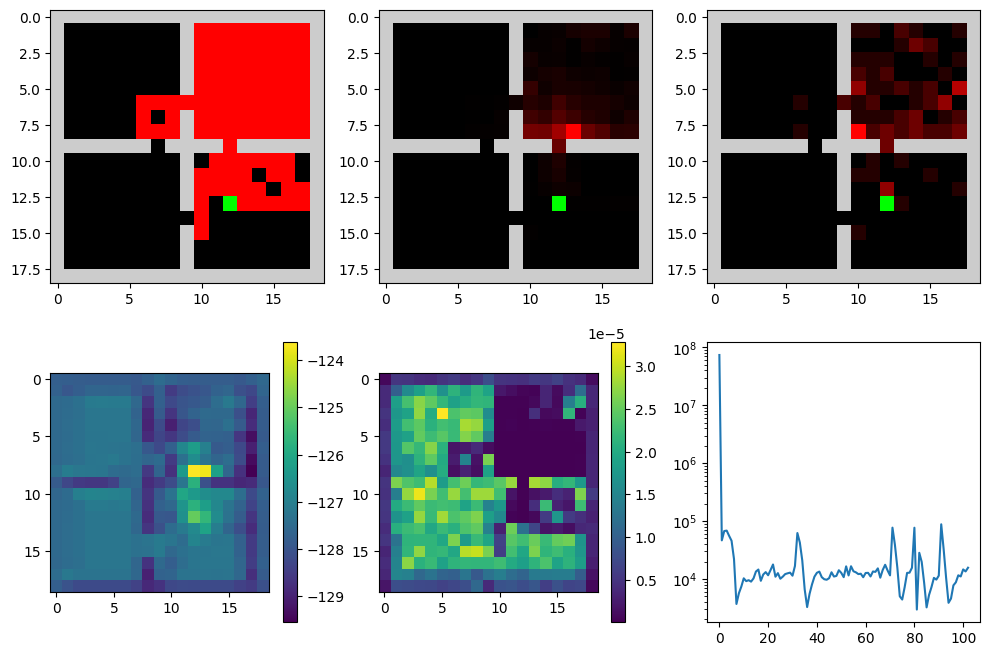

In [4]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12, 8)

env, batch = experiment.env, experiment.memory.sample(len(experiment.memory))[0]

visualise(
    ax = axs[0][0],
    env=env,
    batch=batch,
    density=False
)

visualise(
    ax = axs[0][1],
    env=env,
    batch=batch,
    density=True
)

visualise(
    ax = axs[0][2],
    env= env,
    batch=experiment.logger._engine.results['reset_obs'],
)

experiment_grid = grid(experiment.env)
n = 19
values_v = np.zeros((n,n))
values_r = np.zeros((n,n))
for x in range(n):
    for y in range(n):
        s = torch.tensor(experiment_grid[x,y], device=DEVICE).to(torch.float32)
        s = s.permute((2,0,1))
        v_1 = experiment.value.v(s)
        v_2 = experiment.intrinsic(s.unsqueeze(0))
        values_v[x,y] = v_1.item()
        values_r[x,y] = v_2.item()
# Value Function
im = axs[1][0].imshow(values_v)
fig.colorbar(im, ax=axs[1][0])
# Intrinsic Reward
im = axs[1][1].imshow(values_r)
fig.colorbar(im, ax=axs[1][1])

axs[1][2].plot(experiment.logger._engine.results["value_loss"])
axs[1][2].set_yscale("log")

/home/markhaoxiang/Projects/part_ii_project/venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/markhaoxiang/Projects/part_ii_project/venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


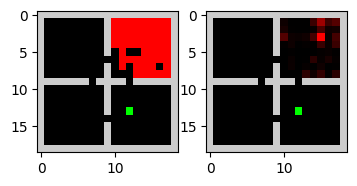

In [5]:
env, batch = experiment_random(steps=2048, seed=0)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(4, 8)
visualise(
    ax = axs[0],
    env=env,
    batch=batch,
    density=False
)

visualise(
    ax = axs[1],
    env=env,
    batch=batch,
    density=True
)


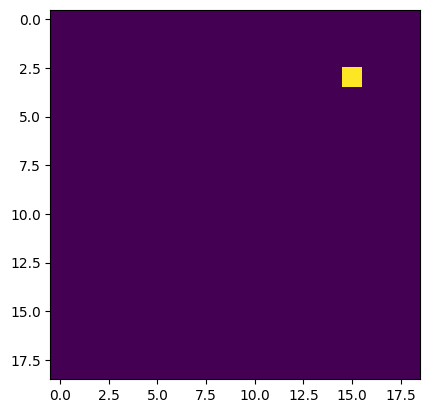

In [6]:
obs, _ = env.reset()

plt.imshow(obs[:,:,2])

In [7]:
np.argmax(obs[:,:,2])

72

In [8]:
import minigrid.core.constants